Compiling model...
'compile' took 0.000308 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.62e-01, 5.73e-02, 3.04e-01]    [1.37e-01, 5.73e-02, 3.04e-01]    []  
1000      [1.67e-03, 8.50e-04, 3.90e-05]    [1.01e-03, 8.50e-04, 3.90e-05]    []  
2000      [2.96e-04, 6.11e-05, 1.46e-06]    [2.09e-04, 6.11e-05, 1.46e-06]    []  

Best model at step 2000:
  train loss: 3.58e-04
  test loss: 2.71e-04
  test metric: []

'train' took 38.754601 s

Compiling model...
'compile' took 0.000405 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.76e+00, 8.73e-02, 1.09e+00, 1.09e+00]    [1.52e+00, 8.73e-02, 1.09e+00, 1.09e+00]    []  
1000      [2.39e-02, 2.84e-02, 1.05e-03, 8.97e-04]    [1.23e-02, 2.84e-02, 1.05e-03, 8.97e-04]    []  
2000      [4.17e-03, 5.06e-03, 2.51e-05, 1.22e-04]    [2.59e-03, 5.06e-03, 2.51e-05, 1.22e-04]    [

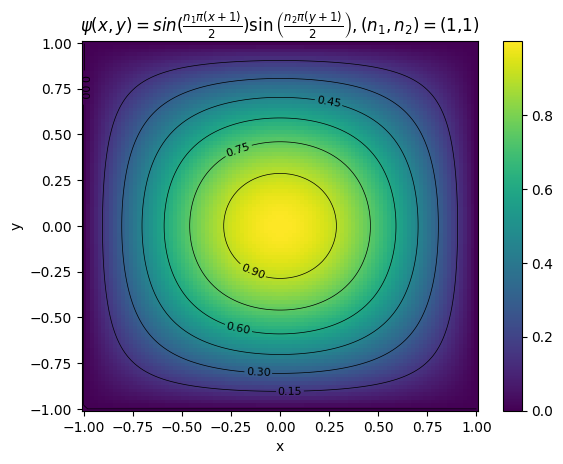

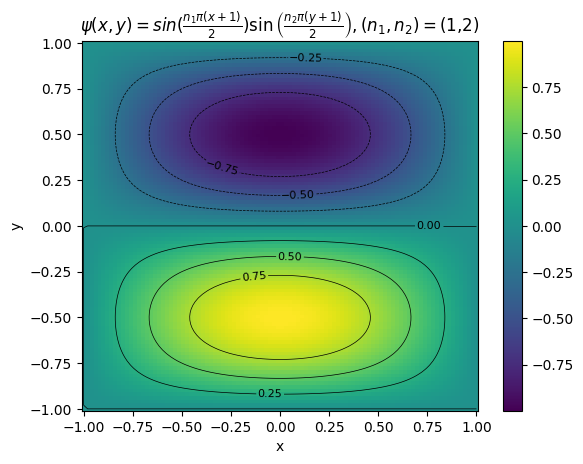

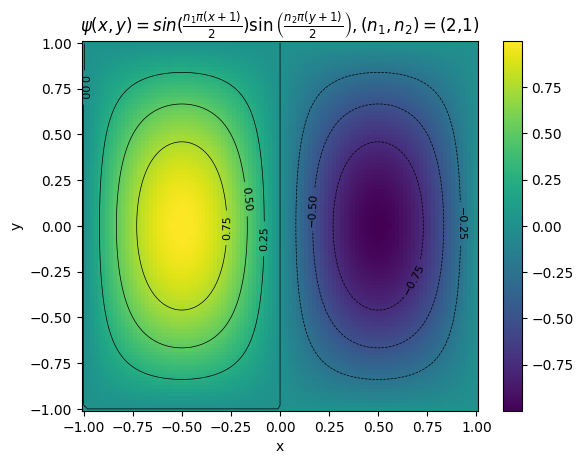

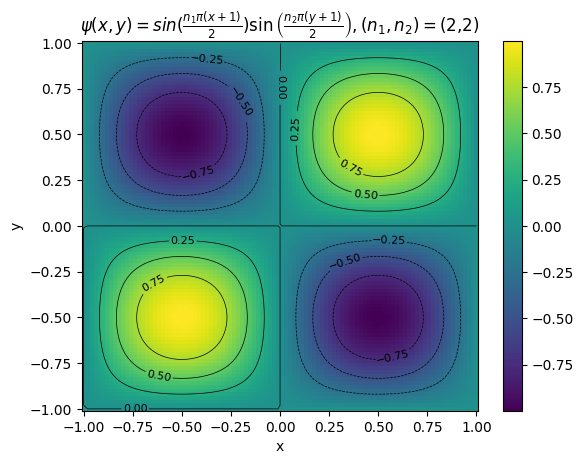

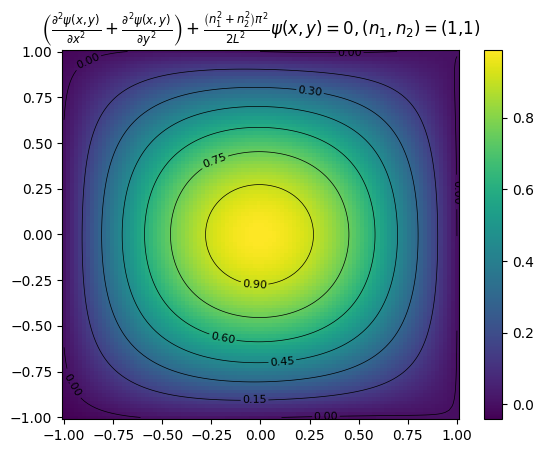

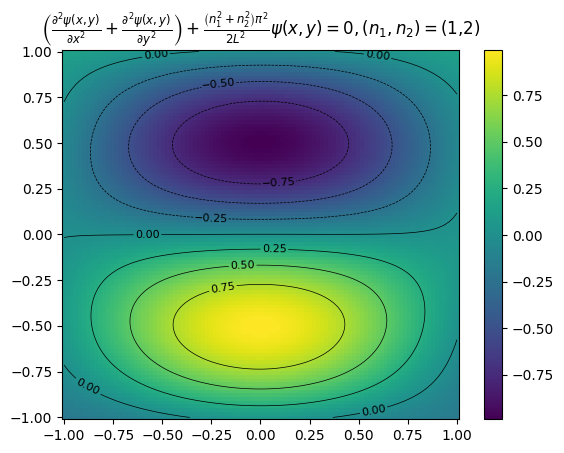

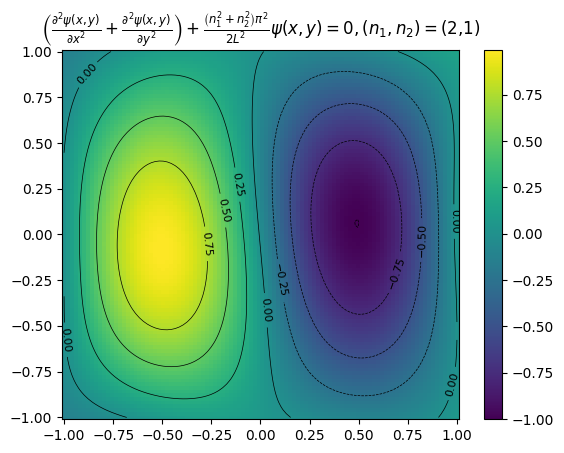

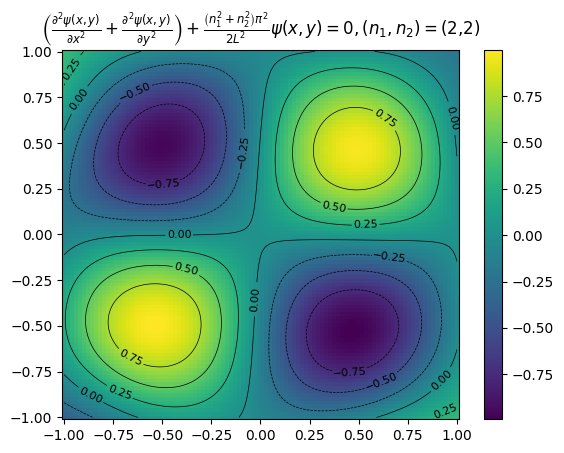

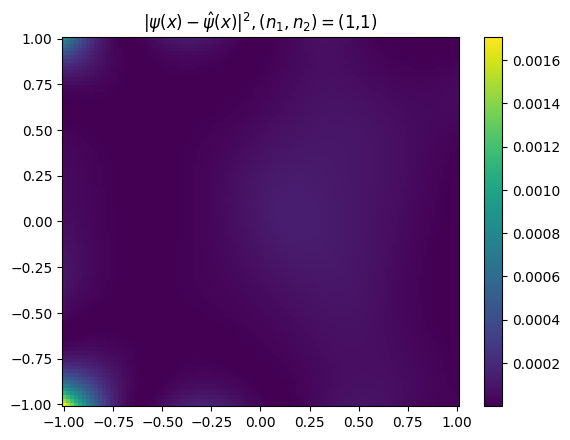

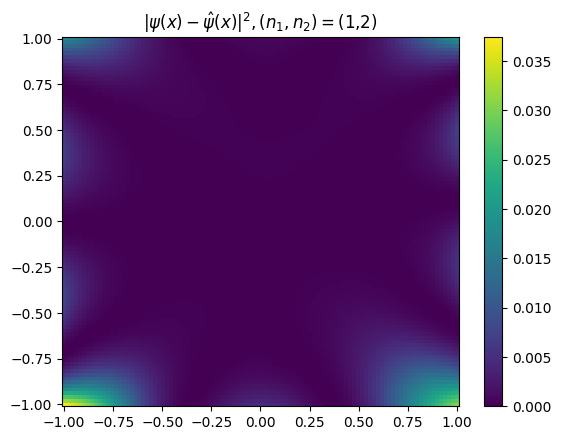

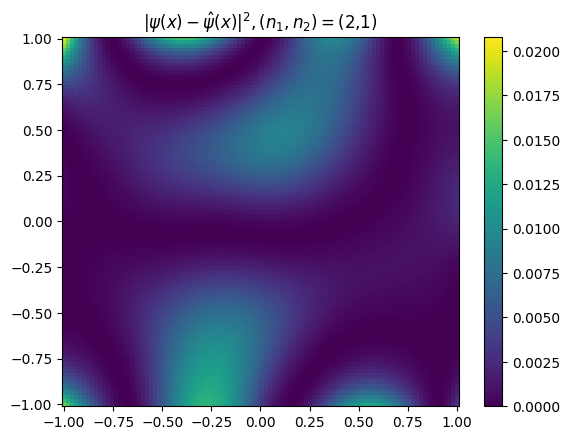

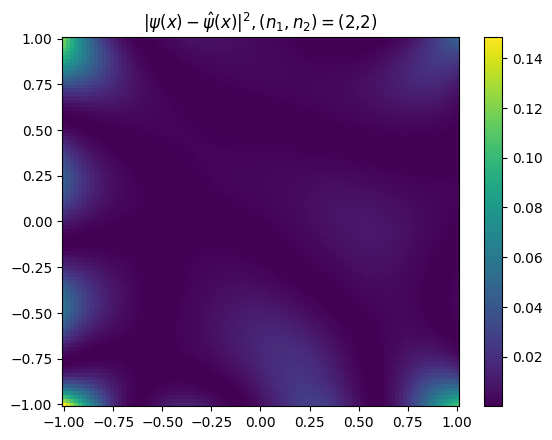

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf

L=2

def psi(x,y,L,n1,n2):
    return (2/L)*np.sin((n1*np.pi*(x+L/2)/L))*np.sin((n2*np.pi*(y+L/2)/L))

def initial_points(points, values):
    tps = []
    for i in range(len(points)):
        tp = dde.PointSetBC(points[i], values[i])
        tps.append(tp)
    return tps

def get_value(points,n1,n2):
    tmp1 = np.sin(n1 * np.pi * (points[:, :, 0] + L / 2) / L)
    tmp2 = np.sin(n2 * np.pi * (points[:, :, 1] + L / 2) / L)
    res = 2 / L * tmp1 * tmp2
    return res.reshape(1, -1)[0]


def show_exact(n1,n2):
    x = np.linspace(-L/2, L/2, 100)
    y = np.linspace(-L/2, L/2, 100)
    X, Y = np.meshgrid(x, y)
    Z = psi(X, Y, L, n1, n2)
    fig, ax = plt.subplots()
    c = ax.pcolormesh(X, Y, Z, cmap='viridis')
    contour = ax.contour(X, Y, Z, colors='black', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8)
    fig.colorbar(c, ax=ax)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$\psi(x, y) = sin{({\frac{n_1 {\pi} \left( x + 1\right)}{2}})} \sin{\left({\frac{n_2 {\pi} \left( y + 1 \right)}{2}} \right)},  (n_1,n_2)=$'+f'({n1},{n2})')
    # plt.savefig(f"lab10/pictures/ψ(x,y) dla (n1,n2)=({n1},{n2})", dpi=350)
    # plt.show()
    return Z
    
Z11=show_exact(1,1)
Z12=show_exact(1,2)
Z21=show_exact(2,1)
Z22=show_exact(2,2)


def pde(x, psi,n1,n2):
    laplacian = dde.grad.hessian(psi, x, i=0, j=0) + dde.grad.hessian(psi, x, i=1, j=1)
    V = (n1**2 + n2**2) * np.pi**2 / (2 * 2**2)
    return 1/2 * laplacian + V * psi

def pde11(x, psi): return pde(x, psi, 1, 1)
def pde12(x, psi): return pde(x, psi, 1, 2)
def pde21(x, psi): return pde(x, psi, 2, 1)
def pde22(x, psi): return pde(x, psi, 2, 2)

def solve(pde,points,values):
    geom = dde.geometry.Rectangle([-L / 2, -L / 2], [L / 2, L / 2])
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary)
    conditions = [bc]
    tps = initial_points(points, values)
    for tp in tps:
        conditions.append(tp)
    data = dde.data.PDE(geom, pde, conditions, num_domain= 400, num_boundary= 60, num_test=10**3)
    net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(iterations=2000)
    return model,train_state


def draw_model( model,n1,n2 ):
    x = np.linspace(-L / 2, L / 2, 100)
    y = np.linspace(-L / 2, L / 2, 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.flatten(), Y.flatten()]).T
    pred = model.predict(xy)
    Z = pred.reshape(X.shape)

    fig, ax = plt.subplots()
    c = ax.pcolormesh(X, Y, Z, cmap='viridis')
    contour = ax.contour(X, Y, Z, colors='black', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8)
    fig.colorbar(c, ax=ax)
    title = r'$\left(\frac{{\partial^2 \psi(x, y)}}{{\partial x^2}} + \frac{{\partial^2 \psi(x, y)}}{{\partial y^2}}\right) +  \frac{\left(n_1^2 + n_2^2\right){\pi^2}}{{2L^2}} \psi(x, y) = 0,  (n_1,n_2)=$'+f'({n1},{n2})'
    plt.title(title)
    # plt.savefig(f"lab10/pictures/DeepXDE ψ(x,y) dla (n1,n2)=({n1},{n2})", dpi=350)
    # plt.show()


points = np.array([[[-0.5, 0]]])
values = get_value(points,1,1)
model11,train_state11 = solve(pde11,points,values)
draw_model(model11,1,1)
# loss_history = model11.train_state.loss_history()

points = np.array([[[0, -0.5]], [[0, 0.5]]])
values = get_value(points,1,2)
model12,train_state12 = solve(pde12,points,values)
draw_model(model12,1,2)

points = np.array([[[-0.5, 0]], [[0.5, 0]]])
values = get_value(points,2,1)
model21,train_state21 = solve(pde21,points,values)
draw_model(model21,2,1)

points = np.array([[[-0.5, -0.5]], [[-0.5, 0.5]], [[0.5, -0.5]], [[0.5, 0.5]],[[0, 0]]])
values = get_value(points,2,2)
model22,train_state22 = solve(pde22,points,values)
draw_model(model22,2,2)

def draw_error(model, Z,n1,n2):
    x = np.linspace(-L / 2, L / 2, 100)
    y = np.linspace(-L / 2, L / 2, 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.flatten(), Y.flatten()]).T
    
    Z_pred = model.predict(xy).reshape(X.shape)
    
    Z_error = (Z - Z_pred)**2

    fig, ax = plt.subplots()
    c = ax.pcolormesh(X, Y, Z_error, cmap='viridis')
    fig.colorbar(c, ax=ax)
    title = r'$|\psi(x) - \hat{\psi}(x)|^2, (n_1,n_2)=$'+f'({n1},{n2})'
    plt.title(title)
    # plt.savefig(f"lab10/pictures/Błąd ψ(x,y) dla (n1,n2)=({n1},{n2})", dpi=350)
    # plt.show()
    
draw_error(model11, Z11,1,1)
draw_error(model12, Z12,1,2)
draw_error(model21, Z21,2,1)
draw_error(model22, Z22,2,2)


    